In [ ]:
"""
Student: Dinh Khac Tuyen
ID: 20214182
"""


!pip install datasets
from datasets import load_dataset
from pprint import pprint
sst_dataset=load_dataset('sst')
pprint(sst_dataset['train'][0])

     |████████████████████████████████| 270 kB 5.5 MB/s 
     |████████████████████████████████| 119 kB 54.7 MB/s 
     |████████████████████████████████| 243 kB 48.3 MB/s 
     |████████████████████████████████| 1.3 MB 39.9 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 294 kB 23.2 MB/s 
     |████████████████████████████████| 142 kB 41.6 MB/s 


Downloading:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

No config specified, defaulting to: sst/default


Downloading:   0%|          | 0.00/6.37M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'label': 0.6944400072097778,
 'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' "
             "and that he 's going to make a splash even greater than Arnold "
             'Schwarzenegger , Jean-Claud Van Damme or Steven Segal .',
 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.",
 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}


In [ ]:

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = phrase.lower()
    return phrase

In [ ]:
vocab=['PAD','UNK']
onetime=[]
for each in sst_dataset['train']:
    sentence=decontracted(each['sentence'])
    words=sentence.split()
    for word in words:
        if word not in vocab:
            if word in onetime:
                vocab.append(word)
            else:
                onetime.append(word)
print(len(vocab))
word2idx={each:i for i,each in enumerate(vocab)}
print(word2idx["the"])

8210
2


In [ ]:
# Define dataset class, data loader

import torch
from torch.utils.data import Dataset
class SentenceDataset(Dataset):
    def __init__(self, sentence_set,encode_len=32):
        self.sentence_set=sentence_set
        self.encode_len=encode_len
    def __getitem__(self, i):    
        sentence=self.sentence_set[i]
        sentence_string=decontracted(sentence["sentence"])
        words=sentence_string.split()
        input_ids=[word2idx[word] if word in word2idx else 1 for word in words]
        if len(input_ids)<self.encode_len:
            input_ids= input_ids+[0]*(self.encode_len-len(input_ids))
        else:
            input_ids=input_ids[:self.encode_len]
        input_tensor=torch.LongTensor(input_ids)
        label=round(sentence['label'])
        return input_tensor,label
    
    def __len__(self):
        return len(self.sentence_set)

encode_len=32 # len of sentence after encode 
dataset={
    "train":SentenceDataset(sst_dataset['train'],encode_len=encode_len),
    "val":SentenceDataset(sst_dataset['validation'],encode_len=encode_len)
}
dataset_sizes={ x: len(dataset[x]) for x in ["train","val"]}
dataloaders={x: torch.utils.data.DataLoader(dataset[x],batch_size=32,shuffle=True,drop_last=True) for x in ["train","val"]}
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# Define a train function
import torch.nn as nn
import math
import numpy as np
import time
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
def train_model(model,n_epoch,lr):
    since = time.time()
    best_acc = 0.0
    
    model=model
    model.to(device)
    criterion=nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr= lr)
    train_loss=[]
    train_acc=[]
    val_acc=[]
    val_loss=[]

    num_epochs=n_epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs= model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == "train":
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
            elif phase =="val":
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase=="val":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    plt.plot(train_loss,label="train_loss")
    plt.plot(val_loss,label="val_loss")
    plt.legend()
    plt.xticks(np.arange(0, num_epochs, num_epochs//10))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(train_acc,label="train_acc")
    plt.plot(val_acc,label="val_acc")
    plt.legend()
    plt.xticks(np.arange(0, num_epochs, num_epochs//10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

In [ ]:
# MLP model

class Baseline(nn.Module):
  def __init__(self, d, length):
    super(Baseline, self).__init__()
    self.embedding = nn.Embedding(len(vocab), d)
    self.layer = nn.Linear(d * length, d, bias=True)
    self.relu = nn.ReLU()
    self.class_layer = nn.Linear(d, 2, bias=True)

  def forward(self, input_tensor):
    emb = self.embedding(input_tensor) # [batch_size, length, d]
    emb_flat = emb.view(emb.size(0), -1) # [batch_size, length*d]
    hidden = self.relu(self.layer(emb_flat))
    logits = self.class_layer(hidden)
    return logits




Epoch 0/39
----------
train Loss: 0.7058 Acc: 0.5213
val Loss: 0.6836 Acc: 0.5286
Epoch 1/39
----------
train Loss: 0.6301 Acc: 0.5998
val Loss: 0.7132 Acc: 0.5005
Epoch 2/39
----------
train Loss: 0.5561 Acc: 0.6566
val Loss: 0.7605 Acc: 0.5032
Epoch 3/39
----------
train Loss: 0.5016 Acc: 0.6986
val Loss: 0.8506 Acc: 0.5359
Epoch 4/39
----------
train Loss: 0.4525 Acc: 0.7300
val Loss: 0.9410 Acc: 0.5050
Epoch 5/39
----------
train Loss: 0.4099 Acc: 0.7594
val Loss: 1.0649 Acc: 0.5377
Epoch 6/39
----------
train Loss: 0.3764 Acc: 0.7814
val Loss: 1.0275 Acc: 0.5468
Epoch 7/39
----------
train Loss: 0.3414 Acc: 0.8034
val Loss: 1.3046 Acc: 0.5486
Epoch 8/39
----------
train Loss: 0.3120 Acc: 0.8257
val Loss: 1.1679 Acc: 0.5513
Epoch 9/39
----------
train Loss: 0.2941 Acc: 0.8345
val Loss: 1.3872 Acc: 0.5386
Epoch 10/39
----------
train Loss: 0.2792 Acc: 0.8487
val Loss: 1.3191 Acc: 0.5313
Epoch 11/39
----------
train Loss: 0.2633 Acc: 0.8544
val Loss: 1.4188 Acc: 0.5250
Epoch 12/39
--

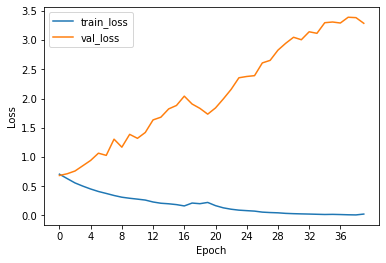

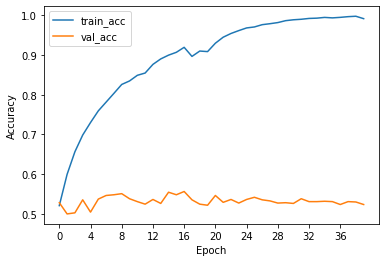

In [ ]:
"""
Result to problem 3.1
"""
d = 128 
model_baseline = Baseline(d, encode_len)
train_model(model_baseline,n_epoch=40,lr=0.1)

In [ ]:
# RNN-based model 

class CustomRNN(nn.Module):
    """
    Based on Elman formula
    """
    def __init__(self, input_size, hidden_size):
        super(CustomRNN, self).__init__()
        self.hidden_size=hidden_size
        
        self.Wh = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.Uh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.Tensor(hidden_size))
        self.Wy = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.by = nn.Parameter(torch.Tensor(hidden_size))
        self.init_weights()
        
    def init_weights(self):
        torch.nn.init.kaiming_uniform_(self.Wh.data,mode="fan_out")
        torch.nn.init.kaiming_uniform_(self.Uh.data,mode="fan_out")
        torch.nn.init.kaiming_uniform_(self.Wy.data,mode="fan_out")
        stdv = 1.0 / math.sqrt(self.hidden_size)
        self.bh.data.uniform_(-stdv, stdv)
        self.by.data.uniform_(-stdv, stdv)
            
    
    def forward(self,x,init_states=None):
        """
        x.shape must be (batch_size, sequence_size, sequence_dim)
        """
        bs, seq_sz, _ = x.size()
        out_seq=[]
        if init_states is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t = init_states
        
        for t in range(seq_sz):
            x_t = x[:, t, :]
            h_t = torch.tanh(torch.mm(x_t, self.Wh) + torch.mm(h_t, self.Uh) + self.bh) 
            y_t = torch.tanh(torch.mm(h_t, self.Wy) + self.by)
            out_seq.append(y_t)  
              
        out_seq = torch.stack(out_seq)
        out_seq = out_seq.permute(1,0,2) # bs*seq_size*hidden_size
        return out_seq

class RNNModel(nn.Module):
    def __init__(self,vocab_size,input_size,hidden_dim):
        super(RNNModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnn = CustomRNN(input_size,hidden_dim)
        #self.rnn = torch.nn.RNN(input_size=input_size,hidden_size=hidden_dim,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2,2)

    def forward(self, x):
        # x must have shape (bs,seq_len,vocab_len)
        out = self.embedding(x)
        out = self.rnn(out)  
        out = out[:, -1, :] # take the last output (bs,hidden_size)
        out = self.fc1(out) 
        out = self.fc2(out)
        return out
    



Epoch 0/99
----------
train Loss: 0.6965 Acc: 0.5082
val Loss: 0.6892 Acc: 0.4959
Epoch 1/99
----------
train Loss: 0.6941 Acc: 0.4996
val Loss: 0.6877 Acc: 0.5014
Epoch 2/99
----------
train Loss: 0.6924 Acc: 0.5090
val Loss: 0.6931 Acc: 0.5005
Epoch 3/99
----------
train Loss: 0.6926 Acc: 0.5021
val Loss: 0.6896 Acc: 0.5005
Epoch 4/99
----------
train Loss: 0.6917 Acc: 0.5051
val Loss: 0.6911 Acc: 0.4968
Epoch 5/99
----------
train Loss: 0.6908 Acc: 0.5114
val Loss: 0.6885 Acc: 0.4623
Epoch 6/99
----------
train Loss: 0.6906 Acc: 0.5061
val Loss: 0.6899 Acc: 0.5014
Epoch 7/99
----------
train Loss: 0.6893 Acc: 0.5162
val Loss: 0.6899 Acc: 0.4986
Epoch 8/99
----------
train Loss: 0.6880 Acc: 0.5163
val Loss: 0.6935 Acc: 0.4905
Epoch 9/99
----------
train Loss: 0.6858 Acc: 0.5211
val Loss: 0.7023 Acc: 0.4959
Epoch 10/99
----------
train Loss: 0.6837 Acc: 0.5218
val Loss: 0.6958 Acc: 0.4986
Epoch 11/99
----------
train Loss: 0.6803 Acc: 0.5293
val Loss: 0.7150 Acc: 0.4905
Epoch 12/99
--

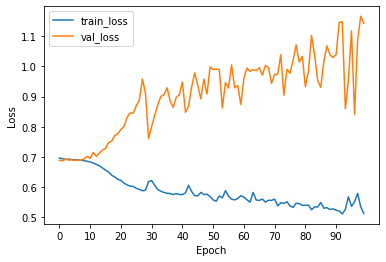

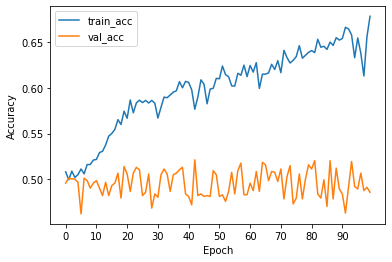

In [ ]:
"""
Result to problem 3.2
"""
rnn_model=RNNModel(len(vocab),128,64)
train_model(rnn_model,n_epoch=100,lr=0.05)

In [ ]:
#LSTM-based model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Define weight matrices, that contains all weight for input, forget, cell, output gate
        self.W = nn.Parameter(torch.Tensor(input_size, hidden_size*4))
        self.U = nn.Parameter(torch.Tensor(hidden_size, hidden_size*4))
        self.b = nn.Parameter(torch.Tensor(hidden_size*4))

        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.kaiming_uniform_(self.W.data,mode="fan_out")
        torch.nn.init.kaiming_uniform_(self.U.data,mode="fan_out")
        stdv = 1.0 / math.sqrt(self.hidden_size)
        self.b.data.uniform_(-stdv, stdv)
    
    def forward(self,x,init_states=None):
        """
        x.shape must be (batch_size, sequence_size, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
        hs=self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            M = torch.mm(x_t, self.W) + torch.mm(h_t, self.U) + self.b

            i_t = torch.sigmoid(M[:,:hs])
            f_t = torch.sigmoid(M[:,hs:2*hs])
            g_t = torch.tanh(M[:,2*hs:3*hs])
            o_t = torch.sigmoid(M[:,3*hs:])
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t)   
        hidden_seq = torch.stack(hidden_seq)
        hidden_seq = hidden_seq.permute(1,0,2) # bs*seq_size*hidden_size
        return hidden_seq,(h_t,c_t)
    
class LSTMModel(nn.Module):
    def __init__(self,vocab_size,input_size,hidden_dim,dropout=0):
        super(LSTMModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.lstm = CustomLSTM(input_size,hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, 2)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self, x):
        # x must have shape(bs,seq_len,vocab_len)
        out = self.embedding(x) 
        out,(h_n,c_n) = self.lstm(out)
        out = out[:, -1, :] # take the last output (bs,hidden_size)
        out = self.dropout(out) 
        out = self.fc1(out) 
        out = self.fc2(out)

        return out
    



Epoch 0/99
----------
train Loss: 0.6946 Acc: 0.5048
val Loss: 0.6880 Acc: 0.4896
Epoch 1/99
----------
train Loss: 0.6941 Acc: 0.5097
val Loss: 0.6852 Acc: 0.4886
Epoch 2/99
----------
train Loss: 0.6933 Acc: 0.5116
val Loss: 0.6868 Acc: 0.4868
Epoch 3/99
----------
train Loss: 0.6934 Acc: 0.5030
val Loss: 0.6849 Acc: 0.5005
Epoch 4/99
----------
train Loss: 0.6930 Acc: 0.5096
val Loss: 0.6883 Acc: 0.4877
Epoch 5/99
----------
train Loss: 0.6929 Acc: 0.5054
val Loss: 0.6858 Acc: 0.4868
Epoch 6/99
----------
train Loss: 0.6929 Acc: 0.5080
val Loss: 0.6856 Acc: 0.4859
Epoch 7/99
----------
train Loss: 0.6929 Acc: 0.4999
val Loss: 0.6849 Acc: 0.5086
Epoch 8/99
----------
train Loss: 0.6929 Acc: 0.5047
val Loss: 0.6851 Acc: 0.4959
Epoch 9/99
----------
train Loss: 0.6921 Acc: 0.5153
val Loss: 0.6853 Acc: 0.5032
Epoch 10/99
----------
train Loss: 0.6923 Acc: 0.5153
val Loss: 0.6859 Acc: 0.4941
Epoch 11/99
----------
train Loss: 0.6911 Acc: 0.5169
val Loss: 0.6882 Acc: 0.4868
Epoch 12/99
--

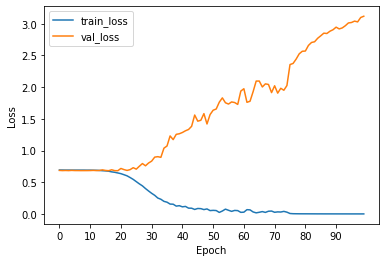

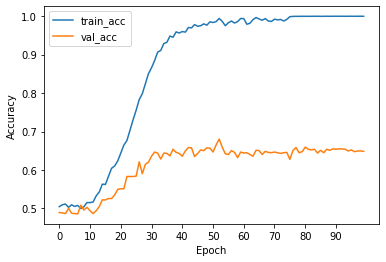

In [ ]:
"""
Result to problem 4.1
"""
lstm_model=LSTMModel(len(vocab),128,64)
train_model(lstm_model,n_epoch=100,lr=0.1)

Epoch 0/99
----------
train Loss: 0.6965 Acc: 0.5002
val Loss: 0.6852 Acc: 0.4959
Epoch 1/99
----------
train Loss: 0.6936 Acc: 0.5036
val Loss: 0.6852 Acc: 0.4959
Epoch 2/99
----------
train Loss: 0.6933 Acc: 0.5089
val Loss: 0.6878 Acc: 0.4859
Epoch 3/99
----------
train Loss: 0.6932 Acc: 0.5034
val Loss: 0.6854 Acc: 0.4841
Epoch 4/99
----------
train Loss: 0.6928 Acc: 0.5108
val Loss: 0.6876 Acc: 0.4877
Epoch 5/99
----------
train Loss: 0.6932 Acc: 0.5027
val Loss: 0.6873 Acc: 0.4886
Epoch 6/99
----------
train Loss: 0.6922 Acc: 0.5176
val Loss: 0.6849 Acc: 0.5041
Epoch 7/99
----------
train Loss: 0.6924 Acc: 0.5051
val Loss: 0.6852 Acc: 0.5014
Epoch 8/99
----------
train Loss: 0.6914 Acc: 0.5130
val Loss: 0.6870 Acc: 0.5023
Epoch 9/99
----------
train Loss: 0.6915 Acc: 0.5131
val Loss: 0.6876 Acc: 0.4896
Epoch 10/99
----------
train Loss: 0.6909 Acc: 0.5144
val Loss: 0.6872 Acc: 0.4850
Epoch 11/99
----------
train Loss: 0.6907 Acc: 0.5194
val Loss: 0.6856 Acc: 0.5050
Epoch 12/99
--

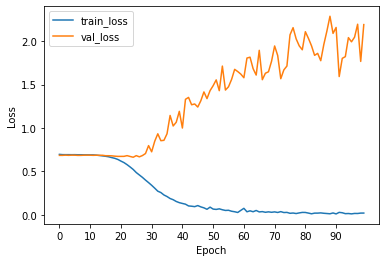

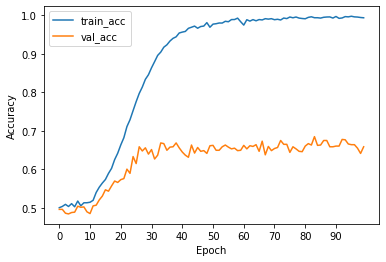

In [ ]:
"""
Result to problem 4.2
"""
lstm_model_with_dropout=LSTMModel(len(vocab),128,64,dropout=0.25)
train_model(lstm_model_with_dropout,n_epoch=100,lr=0.1)

In [ ]:
#Bi-directional, 2 layers LSTM 

class AdvancedLSTMModel(nn.Module):
    def __init__(self,vocab_size,input_size,hidden_dim,dropout=0):
        super(AdvancedLSTMModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.lstm1 = CustomLSTM(input_size,hidden_dim)
        self.lstm2 = CustomLSTM(hidden_dim,hidden_dim)
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, 2)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self, x):
        # x must have shape(bs,seq_len,vocab_len)
        x1 = self.embedding(x) 
        out1,(h_n,c_n) = self.lstm1(x1)
        out1,(h_n,c_n) = self.lstm2(out1)
        out1 = out1[:, -1, :] # take the last output of the forward

        x2 = torch.flip(x1,[1])
        out2,(h_n,c_n) = self.lstm1(x2)
        out2,(h_n,c_n) = self.lstm2(out2)
        out2 = torch.flip(out2,[1])
        out2 = out2[:, 0, :] # take the first of the backward

        out=torch.cat((out1,out2),1)
        out = self.dropout(out) 
        out = self.fc1(out) 
        out = self.fc2(out)

        return out

Epoch 0/69
----------
train Loss: 0.6928 Acc: 0.5174
val Loss: 0.6797 Acc: 0.5441
Epoch 1/69
----------
train Loss: 0.6871 Acc: 0.5548
val Loss: 0.6718 Acc: 0.5713
Epoch 2/69
----------
train Loss: 0.6751 Acc: 0.5755
val Loss: 0.6692 Acc: 0.5486
Epoch 3/69
----------
train Loss: 0.6547 Acc: 0.6145
val Loss: 0.6396 Acc: 0.6158
Epoch 4/69
----------
train Loss: 0.6292 Acc: 0.6490
val Loss: 0.6271 Acc: 0.6331
Epoch 5/69
----------
train Loss: 0.5949 Acc: 0.6835
val Loss: 0.6313 Acc: 0.6458
Epoch 6/69
----------
train Loss: 0.5557 Acc: 0.7176
val Loss: 0.6618 Acc: 0.6349
Epoch 7/69
----------
train Loss: 0.5075 Acc: 0.7540
val Loss: 0.6472 Acc: 0.6567
Epoch 8/69
----------
train Loss: 0.4587 Acc: 0.7891
val Loss: 0.6870 Acc: 0.6421
Epoch 9/69
----------
train Loss: 0.4206 Acc: 0.8113
val Loss: 0.6589 Acc: 0.6848
Epoch 10/69
----------
train Loss: 0.3631 Acc: 0.8388
val Loss: 0.7494 Acc: 0.6658
Epoch 11/69
----------
train Loss: 0.3164 Acc: 0.8682
val Loss: 0.7844 Acc: 0.6603
Epoch 12/69
--

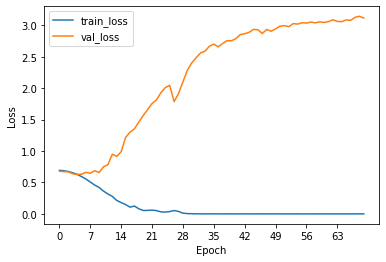

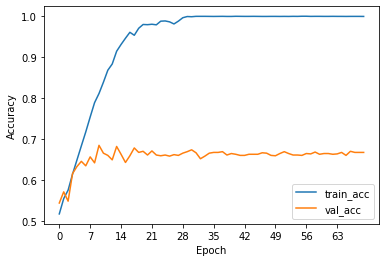

In [ ]:
"""
Result to problem 4.3
"""
advanced_lstm_model=AdvancedLSTMModel(len(vocab),128,64,dropout=0.25)
train_model(advanced_lstm_model,n_epoch=70,lr=0.1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Recreate vocab
vocab_glove = []
word2idx = {}
idx = 0
vectors = []

with open('/content/drive/MyDrive/pytorch_data/glove.6B/glove.6B.50d.txt', 'rb') as f:
  for l in f:
    line = l.decode().split()
    word = line[0]
    vocab_glove.append(word)
    word2idx[word] = idx
    idx += 1
    vect = np.array(line[1:]).astype(np.float)
    vectors.append(vect)

glove = {w: vectors[word2idx[w]] for w in vocab_glove}
print(len(vocab_glove))
# init a matrix contain weight from glove for embedding layer 
matrix_len = len(vocab_glove)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

#for each word in vocab, get the vector of word from glove

for i, word in enumerate(vocab_glove):
    weights_matrix[i] = glove[word]



400000


In [ ]:
class LSTMModelWithPretrained(nn.Module):
    def __init__(self,vocab_size,input_size,hidden_dim,dropout=0):
        super(LSTMModelWithPretrained,self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.embedding.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
        # freeze the embedding layer because we use pretrained weights
        self.embedding.weight.requires_grad = False  
        self.lstm = CustomLSTM(input_size,hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, 2)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self, x):
        # x must have shape(bs,seq_len,vocab_len)
        out = self.embedding(x) 
        out,(h_n,c_n) = self.lstm(out)
        out = out[:, -1, :] # take the last output (bs,hidden_size)
        out = self.dropout(out) 
        out = self.fc1(out) 
        out = self.fc2(out)

        return out

In [ ]:
# Redefine dataset class because now we use different vocab

import torch
from torch.utils.data import Dataset
class SentenceDataset(Dataset):
    def __init__(self, sentence_set,encode_len=32):
        self.sentence_set=sentence_set
        self.encode_len=encode_len
    def __getitem__(self, i):    
        sentence=self.sentence_set[i]
        sentence_string=decontracted(sentence["sentence"])
        words=sentence_string.split()
        # for unknown word, put a random value 
        input_ids=[word2idx[word] if word in word2idx else np.random.randint(1,len(vocab_glove)) for word in words]
        # to add padding, simply put zero 
        if len(input_ids)<self.encode_len:
            input_ids= input_ids+[0]*(self.encode_len-len(input_ids))
        else:
            input_ids=input_ids[:self.encode_len]
        input_tensor=torch.LongTensor(input_ids)
        label=round(sentence['label'])
        return input_tensor,label
    
    def __len__(self):
        return len(self.sentence_set)

encode_len=32 # len of sentence after encode 
dataset={
    "train":SentenceDataset(sst_dataset['train'],encode_len=encode_len),
    "val":SentenceDataset(sst_dataset['validation'],encode_len=encode_len)
}
dataset_sizes={ x: len(dataset[x]) for x in ["train","val"]}
dataloaders={x: torch.utils.data.DataLoader(dataset[x],batch_size=32,shuffle=True,drop_last=True) for x in ["train","val"]}
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Epoch 0/99
----------
train Loss: 0.6956 Acc: 0.5054
val Loss: 0.6848 Acc: 0.4977
Epoch 1/99
----------
train Loss: 0.6939 Acc: 0.5123
val Loss: 0.6843 Acc: 0.5232
Epoch 2/99
----------
train Loss: 0.6928 Acc: 0.5103
val Loss: 0.6892 Acc: 0.4859
Epoch 3/99
----------
train Loss: 0.6894 Acc: 0.5418
val Loss: 0.6694 Acc: 0.5804
Epoch 4/99
----------
train Loss: 0.6697 Acc: 0.6001
val Loss: 0.6522 Acc: 0.6349
Epoch 5/99
----------
train Loss: 0.6241 Acc: 0.6629
val Loss: 0.5973 Acc: 0.6794
Epoch 6/99
----------
train Loss: 0.5954 Acc: 0.6876
val Loss: 0.5761 Acc: 0.6903
Epoch 7/99
----------
train Loss: 0.5768 Acc: 0.7027
val Loss: 0.5756 Acc: 0.6948
Epoch 8/99
----------
train Loss: 0.5693 Acc: 0.7107
val Loss: 0.5460 Acc: 0.7084
Epoch 9/99
----------
train Loss: 0.5664 Acc: 0.7144
val Loss: 0.5372 Acc: 0.7212
Epoch 10/99
----------
train Loss: 0.5572 Acc: 0.7163
val Loss: 0.5374 Acc: 0.7166
Epoch 11/99
----------
train Loss: 0.5514 Acc: 0.7219
val Loss: 0.5497 Acc: 0.7139
Epoch 12/99
--

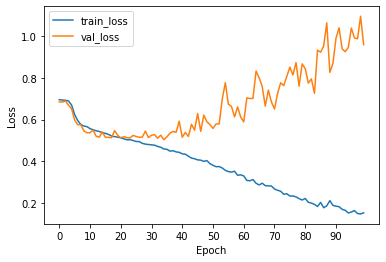

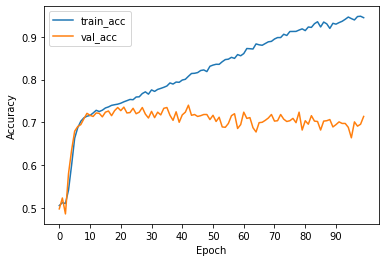

In [ ]:
"""
Result to problem 5.1
"""
lstm_model_with_pretrain=LSTMModelWithPretrained(len(vocab_glove),50,64,dropout=0.25)
train_model(lstm_model_with_pretrain,n_epoch=100,lr=0.1)